# Multilayer Fully Connected Network with Exponential Decay Learning Rate (dropout 50% and 30%)

## Summary of the network
>
> **Network structure**
* Dropout1: (?, 4096)
* Hidden: (?, 512)
* Dropout2: (?, 512)
* Hidden1: (?, 258)
* Dropout3: (?, 258)
* hidden2: (?, 128)
* Dropout4: (?, 128)
* Output: (?, 4)

>
>**Hyper-parameters**: Loss function: mean_ce + alpha*l2_term (hidden and output layer); Gradient descent Optimizer, L2 regularization (alpha: 0.05), Exponential Decay learning rate; batch size 100
>
>**Accuracy on test (training data set) = 0.830**

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import tensorflow as tf

import random
from sklearn import ensemble

from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Activate Seaborn style
sns.set()

C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-

## Import data

In [2]:
# Load the train npz file
with np.load('Cifar4-train.npz', allow_pickle=False) as cifar_df:
    # It's a dictionary-like object
    cifar4 = dict(cifar_df.items())

In [3]:
X=cifar4['overfeat']
y=cifar4['labels']
names=cifar4['names']

print(X.shape, X.dtype)
print(y.shape, y.dtype)
print(names.shape, names.dtype)

(5000, 4096) float32
(5000,) int64
(4,) <U8


In [4]:
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    cifar4['overfeat'], cifar4['labels'],
    test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

# Rescale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 4096) (3200,)
Valid: (800, 4096) (800,)
Test: (1000, 4096) (1000,)


In [5]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

### Define the graph: Hidden, dropout and output layers

In [6]:
# Define the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Create training placeholder for the Dropout
    training = tf.placeholder(dtype=tf.bool)
    
    # Apply dropout to the input layer X with a rate of 0.5
    dropout1 = tf.layers.dropout(
        X, rate=0.5, seed=0, training=training)
    print('Dropout1:', dropout1.shape)

    # Hidden layer with 512 units
    hidden = tf.layers.dense(
        dropout1, 512, activation=tf.nn.relu, # ReLU (before X)
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    print('Hidden:', hidden.shape)
    
    # Apply dropout to the hidden layer with a rate of 0.3
    dropout2 = tf.layers.dropout(
        hidden, rate=0.3, seed=0, training=training)
    print('Dropout2:', dropout2.shape)
    
    # Hidden 1 layer with 258 units
    hidden1 = tf.layers.dense(
        dropout2, 258, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden1'
    )
    print('Hidden1:', hidden1.shape)
    
    # Apply dropout to the hidden 1 layer with a rate of 0.3
    dropout3 = tf.layers.dropout(
        hidden1, rate=0.3, seed=0, training=training)
    print('Dropout3:', dropout3.shape)
    
    # Hidden 2 layer with 128 units
    hidden2 = tf.layers.dense(
        dropout3, 128, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden2'
    )
    print('hidden2:', hidden2.shape)
    
    # Apply dropout to the hidden 2 layer with a rate of 0.5
    dropout4 = tf.layers.dropout(
        hidden2, rate=0.5, seed=0, training=training)
    print('Dropout4:', dropout4.shape)

    # Output layer with 4 units
    logits = tf.layers.dense(
        dropout4, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    print('Output:', logits.shape)

Dropout1: (?, 4096)
Hidden: (?, 512)
Dropout2: (?, 512)
Hidden1: (?, 258)
Dropout3: (?, 258)
hidden2: (?, 128)
Dropout4: (?, 128)
Output: (?, 4)


### Inspect variables

In [7]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)

<tf.Variable 'hidden/kernel:0' shape=(4096, 512) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'hidden1/kernel:0' shape=(512, 258) dtype=float32_ref>
<tf.Variable 'hidden1/bias:0' shape=(258,) dtype=float32_ref>
<tf.Variable 'hidden2/kernel:0' shape=(258, 128) dtype=float32_ref>
<tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(128, 4) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(4,) dtype=float32_ref>


### Define the graph: Hidden/output layer weights + Loss function with exponential decay learning rate

In [8]:
with graph.as_default():
    
    # Hidden layer weights
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
    
    # Output layer weight
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
    
    # L2 term
    l2_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)

    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)

    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    loss = mean_ce + alpha*l2_term
    
    # Define the parameters of the decayed learning rate
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.9, staircase=True)
    
    # Passing global_step to minimize() will increment it at each step.
    learning_step = tf.train.GradientDescentOptimizer(learning_rate)    

    # Minimize cross-entropy
    train_op = learning_step.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [9]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 100):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                training: True, # Apply dropout
                alpha: 0.05 # Regularization strength
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
        # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test,
        training: False # Do not apply dropout
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.673 train: 0.370 (mean)
Epoch 2 - valid: 0.734 train: 0.491 (mean)
Epoch 3 - valid: 0.757 train: 0.565 (mean)
Epoch 4 - valid: 0.770 train: 0.625 (mean)
Epoch 5 - valid: 0.772 train: 0.655 (mean)
Epoch 6 - valid: 0.791 train: 0.685 (mean)
Epoch 7 - valid: 0.793 train: 0.696 (mean)
Epoch 8 - valid: 0.804 train: 0.721 (mean)
Epoch 9 - valid: 0.812 train: 0.732 (mean)
Epoch 10 - valid: 0.814 train: 0.744 (mean)
Epoch 11 - valid: 0.816 train: 0.748 (mean)
Epoch 12 - valid: 0.814 train: 0.759 (mean)
Epoch 13 - valid: 0.819 train: 0.772 (mean)
Epoch 14 - valid: 0.815 train: 0.776 (mean)
Epoch 15 - valid: 0.815 train: 0.782 (mean)
Epoch 16 - valid: 0.809 train: 0.786 (mean)
Epoch 17 - valid: 0.815 train: 0.792 (mean)
Epoch 18 - valid: 0.816 train: 0.798 (mean)
Epoch 19 - valid: 0.817 train: 0.801 (mean)
Epoch 20 - valid: 0.817 train: 0.800 (mean)
Epoch 21 - valid: 0.817 train: 0.810 (mean)
Epoch 22 - valid: 0.817 train: 0.813 (mean)
Epoch 23 - valid: 0.817 train: 0.821 (mea

### Plot the accuracy

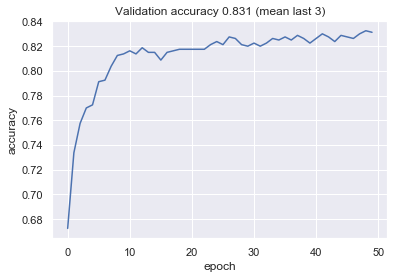

In [10]:
# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
#Save the accuracy of the Best Multilayer Fully Connected Network (3 hidden layers, exp. decay lr)
three_hidden_decaylr_Network=0.831
%store three_hidden_decaylr_Network

Stored 'three_hidden_decaylr_Network' (float)
